# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

##  Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Ивегеш Ольга
- Дата: 26.06.2025

## Цели и задачи проекта

<font color='#777778'>Часть 1. Проверка гипотезы в Python и составление аналитической записки. 
    Часть 2. Анализ результатов A/B-тестирования</font>

## Описание данных

Данные
https://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов.
Структура файла:
user_id — идентификатор пользователя;
group — группа пользователя;
ab_test — название теста;
device — устройство, с которого происходила регистрация.
https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года;
Структура файла:
user_id — идентификатор пользователя;


## Содержимое проекта

- загрузка данных и знакомство с ними
- поиск дубликатов
- удаление дкбликатов
- изучение данных
- проверка гипотезы 
- выводы

---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import fabs
import seaborn as sns
!pip install matplotlib-venn -q
from matplotlib_venn import venn2, venn3 

In [2]:
yandex_knigi_data = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')
yandex_knigi_data.head(5)

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
yandex_knigi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
yandex_knigi_data.duplicated(subset='puid').sum()

244

In [5]:
yandex_knigi_data=yandex_knigi_data.drop_duplicates(subset='puid', keep='first').reset_index(drop=True)
yandex_knigi_data.duplicated(subset='puid').sum()

0

In [6]:
unique_users = yandex_knigi_data.groupby(['city']).agg({'puid': 'nunique'})
unique_users

,puid
city,
Москва,6234
Санкт-Петербург,2306


In [7]:
hours_users = yandex_knigi_data.groupby(['city']).agg({'hours': 'sum'})
hours_users

,hours
city,
Москва,67832.727924
Санкт-Петербург,25975.783344


Разделение на группы по городу. Группа Москва сильно больше, чем группа Санкт-Петербург. Сумма часов в Москве тоже значительно выше. 

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [8]:
from scipy.stats import ttest_ind
moscow_times = yandex_knigi_data[yandex_knigi_data['city'] == 'Москва']['hours']
spb_times = yandex_knigi_data[yandex_knigi_data['city'] == 'Санкт-Петербург']['hours']

# Выполнение одностороннего t-теста
test_result = ttest_ind(spb_times, moscow_times, alternative='less')

alpha = 0.05
test_result.pvalue

if test_result.pvalue <= alpha:
    print(f'Полученное значение p_value:{round(test_result.pvalue,2)} меньше установленного значения alpha:{alpha}.\nОтвергаем нулевую гипотезу о равенстве средних двух выборок')
else:
    print(f'Полученное значение p_value:{round(test_result.pvalue,2)} больше установленного значения alpha:{alpha}.\nНе отвергаем нулевую гипотезу о равенстве средних двух выборок')

Полученное значение p_value:0.66 больше установленного значения alpha:0.05.
Не отвергаем нулевую гипотезу о равенстве средних двух выборок


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбран односторонниц t-тест и уровень статистической значимости равный 0.05.

- p-value =0.66.

- Полученный p-value больше установленного значения 0.05.

- Не отвергаем нулевую гипотезу о равенстве средних двух выборок. Привычки жителей двух мегаполисов не отличаются.


----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:
данные о действиях пользователей и распределении их на группы,
техническое задание.
Оцените корректность проведения теста и проанализируйте его результаты

- загрузка данных и знакомство с ними
- изучение данных
- оценка корректности проведения теста
- оценка достаточности размера выборки
- оценка теста
- выводы

## 2. Загрузите данные, оцените их целостность.


In [9]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [10]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [11]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [12]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [13]:
unique_users = participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})
unique_users

user_id
ab_test                 group         
interface_eu_test       A         5383
                        B         5467
recommender_system_test A         2747
                        B          928

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [14]:
ntests_per_user = participants.groupby('user_id').agg({'ab_test': 'nunique'}).sort_values(by = 'ab_test', ascending = False).reset_index()
print('Пользователей, попавших в оба теста:', ntests_per_user[ntests_per_user['ab_test'] > 1]['user_id'].count())

Пользователей, попавших в оба теста: 887


In [15]:
# Исключаем пользователей, попавших в оба теста:
test_participants = participants[~participants['user_id'].isin(ntests_per_user[ntests_per_user['ab_test'] > 1]['user_id'].values)]

# Оставляем пользователей только нашего теста:
test_participants = test_participants[test_participants['ab_test'] == 'interface_eu_test']

test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test           group         
interface_eu_test A         4952
                  B         5011

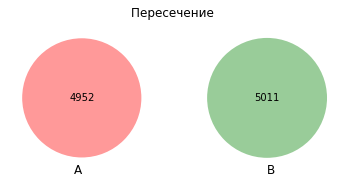

In [16]:
#создаем срез каждой группы пользователем
A = set(test_participants[(test_participants['group'] == 'A')]['user_id'].dropna().unique())
B = set(test_participants[(test_participants['group'] == 'B')]['user_id'].dropna().unique())

# Строим диаграмму Венна
venn2([A, B], set_labels=('A', 'B'))

# Отображаем график
plt.title("Пересечение ")
plt.show() 

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [17]:
# События, совершённые участниками нашего теста:
test_events = events[events['user_id'].isin(test_participants['user_id'])]

# Добавим информацию о группе, в которую попал каждый пользователь:
test_events = test_events.merge(test_participants, on = 'user_id')

In [18]:
ntest_events = test_events['user_id'].nunique()

print('Количество уникальных пользователей, совершавших действия в системе:', ntest_events)


Количество уникальных пользователей, совершавших действия в системе: 9963


In [19]:
test_events['event_dt'] = test_events['event_dt'].dt.date
test_events

,user_id,event_dt,event_name,details,group,ab_test,device
0,5F506CEBEDC05D30,2020-12-06,registration,0.0,A,interface_eu_test,iPhone
1,5F506CEBEDC05D30,2020-12-07,login,NaN,A,interface_eu_test,iPhone
2,5F506CEBEDC05D30,2020-12-07,login,NaN,A,interface_eu_test,iPhone
3,5F506CEBEDC05D30,2020-12-09,login,NaN,A,interface_eu_test,iPhone
4,5F506CEBEDC05D30,2020-12-09,product_page,NaN,A,interface_eu_test,iPhone
...,...,...,...,...,...,...,...
73810,16CCB1C8C4DCF1AF,2020-12-23,registration,0.0,A,interface_eu_test,Mac
73811,16CCB1C8C4DCF1AF,2020-12-23,login,NaN,A,interface_eu_test,Mac
73812,2DDC948BD76ABC57,2020-12-24,registration,-4.29,B,interface_eu_test,iPhone
73813,2DDC948BD76ABC57,2020-12-24,login,NaN,B,interface_eu_test,iPhone


In [20]:
events = test_events.groupby('event_name').agg(count = ('user_id', 'count')).sort_values('count', ascending=False).reset_index()
display(events)

,event_name,count
0,login,27360
1,product_page,17614
2,registration,9963
3,purchase,9487
4,product_cart,9391


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [21]:
min_event_dates = test_events.groupby('user_id')['event_dt'].min().reset_index()
test_events = test_events.merge(min_event_dates.rename(columns={'event_dt': 'registration_date'}), on='user_id', how='left')
test_events['days_since_registration'] = (test_events['event_dt'] - test_events['registration_date']).dt.days
filtered = test_events[test_events['days_since_registration'] <= 7]
filtered

,user_id,event_dt,event_name,details,group,ab_test,device,registration_date,days_since_registration
0,5F506CEBEDC05D30,2020-12-06,registration,0.0,A,interface_eu_test,iPhone,2020-12-06,0
1,5F506CEBEDC05D30,2020-12-07,login,NaN,A,interface_eu_test,iPhone,2020-12-06,1
2,5F506CEBEDC05D30,2020-12-07,login,NaN,A,interface_eu_test,iPhone,2020-12-06,1
3,5F506CEBEDC05D30,2020-12-09,login,NaN,A,interface_eu_test,iPhone,2020-12-06,3
4,5F506CEBEDC05D30,2020-12-09,product_page,NaN,A,interface_eu_test,iPhone,2020-12-06,3
...,...,...,...,...,...,...,...,...,...
73810,16CCB1C8C4DCF1AF,2020-12-23,registration,0.0,A,interface_eu_test,Mac,2020-12-23,0
73811,16CCB1C8C4DCF1AF,2020-12-23,login,NaN,A,interface_eu_test,Mac,2020-12-23,0
73812,2DDC948BD76ABC57,2020-12-24,registration,-4.29,B,interface_eu_test,iPhone,2020-12-24,0
73813,2DDC948BD76ABC57,2020-12-24,login,NaN,B,interface_eu_test,iPhone,2020-12-24,0


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [22]:
from statsmodels.stats.power import TTestIndPower
import math  # Импортируем библиотеку math

# Задаём параметры
alpha = 0.05          # Уровень значимости
power = 0.8           # Мощность теста
base_conv_rate = 0.30 # Базовая конверсия
mde = 0.03            # Минимальный детектируемый эффект (разница в конверсиях)

# Стандартизация эффекта (эффект Коэна)
std_dev = math.sqrt(base_conv_rate * (1 - base_conv_rate))
cohen_d = mde / std_dev

# Инициализируем класс TTestIndPower
analysis = TTestIndPower()

# Рассчитываем размер выборки
sample_size = analysis.solve_power(effect_size=cohen_d, alpha=alpha, power=power, alternative="two-sided")

# Округлим вверх до целого числа
sample_size_per_group = math.ceil(sample_size)

# Общий объём выборки (так как у нас две группы)
total_sample_size = 2 * sample_size_per_group

print(f"Необходимый размер выборки для каждой группы: {sample_size_per_group}")
print(f"Общий объем выборки (суммарно для обеих групп): {total_sample_size}")

Необходимый размер выборки для каждой группы: 3664
Общий объем выборки (суммарно для обеих групп): 7328


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [23]:
# Количество покупателей (только посетители, совершившие покупку)
buyers_count = filtered.query('event_name == "purchase"').groupby('group')['user_id'].count()

# Общее количество посетителей
visitors_count = filtered.groupby('group')['user_id'].count()

# Объединяем оба показателя вместе
result = pd.concat([buyers_count, visitors_count], keys=["Покупатели", "Посетители"], axis=1)
result

,Покупатели,Посетители
group,,
A,2827,31753
B,3673,33092


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

1. Рост числа покупателей:
Группа B демонстрирует значительное повышение числа покупателей (+846 покупателей)

2. Эффективность проведенных изменений:
Данные указывают на положительный эффект нововведений в группе B. Возможно, тестируемые изменения улучшили опыт пользователей, стимулировали больше покупок и повысили вовлечённость. Тем не менее, нужно дополнительно проверить статистическую значимость этих изменений и удостовериться, что рост не вызван случайностью.

In [26]:
data = {
    'A': {'покупатели': 2827, 'посетители': 31753},
    'B': {'покупатели': 3673, 'посетители': 33092}
}

def relative_difference(value1, value2):
    """Вычисляет относительное различие между двумя значениями."""
    return abs((value1 - value2) / value1) * 100

# Вычисляем относительные различия
for category in ['покупатели', 'посетители']:
    diff_percent = relative_difference(data['A'][category], data['B'][category])
    print(f'Относительная разница {category}: {diff_percent:.2f}%')

Относительная разница покупатели: 29.93%
Относительная разница посетители: 4.22%


Относительная разница по покупателям составляет около 30%, показывая значительное увеличение числа покупателей в группе B.
Относительная разница по количеству посетителей меньше (~4%), что свидетельствует о незначительном изменении уровня посещения между группами.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Постановка гипотез:
- Нулевая гипотеза  : Конверсия в группе A не меньше, чем в группе B 
- Альтернативная гипотеза : Конверсия в группе A ниже, чем в группе B

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

n_a = 31753
n_b = 33092
m_a = 2827
m_b = 3673
p_a = m_a / n_a
p_b = m_b / n_b
print(f'p_a = {p_a}, p_b = {p_b}')
print('')

#устанавливаем коэффициент статистической значимости alpha
alpha = 0.05

#проводим z-тест
stats_ztest, p_value_ztest = proportions_ztest([m_a,m_b],
                                  [n_a,n_b],
                                  alternative = 'smaller' #Так как H_1 = p_a < p_b
                                  )
print(f'p_value равняется {p_value_ztest}')

# Принятие решения
if p_value_ztest <= alpha:
    print(f'Полученное значение p_value: {p_value_ztest} меньше alpha: {alpha}. Принимаем альтернативную гипотезу.')
else:
    print(f'Полученное значение {p_value_ztest} больше alpha: {alpha}. Нулевая гипотеза не может быть отвергнута.')

1. Улучшение конверсии:
Расчёт конверсии (отношения числа покупателей к числу посетителей) даёт возможность сравнить, насколько эффективно пользователи совершали покупки в разных группах:

Группа A: Конверсия равна 
2827 / 31753 ≈ 8.9%
Группа B: Конверсия равна 
3673 / 33092 ≈ 11.2 %

Видно существенное улучшение конверсии в группе B, что свидетельствует о положительном влиянии проводимых мероприятий.